# XGBoost DDI Analysis and Training - Bias Reduction & Optimization

## 🎯 Purpose: Extreme Gradient Boosting for Maximum Predictive Sensitivity

**Algorithm:** XGBoost Classifier (Boosting Framework)

**Key Characteristics:**
- **Sequential tree building** to correct errors of previous models
- **Bias reduction** through iterative error correction
- **High sensitivity** for hard-to-classify instances
- **Excellent for imbalanced data** (underrepresented "Major" interactions)
- **Maximum recall** for high-risk safety threats

**Why XGBoost for DDI Detection?**

Unlike Random Forest which builds independent trees in parallel (reducing variance), XGBoost employs a **Boosting framework** where trees are built sequentially. Each new tree focuses on correcting the mistakes of the previous ensemble, making it highly effective at:

1. **Detecting rare but critical interactions** (Major severity class)
2. **Reducing bias** in predictions (complements RF's variance reduction)
3. **Maximizing recall** for patient safety-critical cases
4. **Handling class imbalance** through focused error correction

**Expected Outcome:** Highest recall for "Major" interactions while maintaining overall accuracy competitive with or exceeding Random Forest.

---

## Dataset: Malaysian Hypertension Medications

- **29 drugs** across 5 classes (ACEI, ARB, Beta-Blocker, CCB, Diuretic)
- **406 drug pairs** (all possible combinations)
- **Target:** Final_Severity (Major, Moderate, Minor)
- **Goal:** Predict interaction severity to support safer prescribing

---

# Part 1: Setup and Data Loading

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("✓ Libraries imported successfully")
print(f"XGBoost version: {xgb.__version__}")

✓ Libraries imported successfully
XGBoost version: 3.1.2


## Step 2: Load Dataset

In [2]:
# Load the dataset
df = pd.read_csv('FYP_DrugBank_Inclusive.csv')

print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nTotal drug pairs: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

DATASET OVERVIEW

Total drug pairs: 406
Columns: ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class', 'DrugBank_Severity', 'DrugBank_Text', 'Final_Severity', 'XAI_Rule_A_Mortality', 'XAI_Rule_B_Tolerability', 'XAI_Rule_C_CCB_RAAS_Combo', 'XAI_Rule_D_Diuretic', 'XAI_Rule_E_BetaBlocker', 'XAI_Combined_Clinical_Notes']

First few rows:


,Drug_A_Name,Drug_B_Name,Drug_A_Class,Drug_B_Class,DrugBank_Severity,DrugBank_Text,Final_Severity,XAI_Rule_A_Mortality,XAI_Rule_B_Tolerability,XAI_Rule_C_CCB_RAAS_Combo,XAI_Rule_D_Diuretic,XAI_Rule_E_BetaBlocker,XAI_Combined_Clinical_Notes
0,Captopril,Enalapril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe excretion of Captopril can ...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
1,Captopril,Lisinopril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
2,Captopril,Perindopril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
3,Captopril,Ramipril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...
4,Captopril,Imidapril,ACEI,ACEI,Moderate,DESCRIPTION\n\nThe risk or severity of angioed...,Moderate,Clinical Note: ACE Inhibitors are prioritized ...,Clinical Note: ACE Inhibitors carry a 3.2-fold...,NaN,NaN,NaN,[RULE A - Mortality] Clinical Note: ACE Inhibi...


## Step 3: Data Exploration and Quality Check

In [3]:
print("="*80)
print("DATA QUALITY CHECK")
print("="*80)

# Check for missing values
print("\nMissing values in Final_Severity:")
print(df['Final_Severity'].isna().sum())

# Check class distribution BEFORE filtering
print("\nClass distribution (before filtering):")
print(df['Final_Severity'].value_counts(dropna=False))

# Filter out rows without Final_Severity
df_valid = df.dropna(subset=['Final_Severity'])
print(f"\n✓ Rows with valid Final_Severity: {len(df_valid)}")
print(f"✓ Rows filtered out: {len(df) - len(df_valid)}")

# Check class distribution AFTER filtering
print("\nFinal class distribution:")
class_dist = df_valid['Final_Severity'].value_counts().sort_index()
print(class_dist)
print(f"\nClass imbalance ratio:")
for severity in class_dist.index:
    print(f"  {severity}: {class_dist[severity]/len(df_valid)*100:.1f}%")

DATA QUALITY CHECK

Missing values in Final_Severity:
0

Class distribution (before filtering):
Final_Severity
Moderate         212
Minor            142
NoInteraction     44
Major              8
Name: count, dtype: int64

✓ Rows with valid Final_Severity: 406
✓ Rows filtered out: 0

Final class distribution:
Final_Severity
Major              8
Minor            142
Moderate         212
NoInteraction     44
Name: count, dtype: int64

Class imbalance ratio:
  Major: 2.0%
  Minor: 35.0%
  Moderate: 52.2%
  NoInteraction: 10.8%


## Step 4: Visualize Class Distribution

**Critical for XGBoost:** Understanding class imbalance is essential because XGBoost excels at handling imbalanced datasets through:
- `scale_pos_weight` parameter
- Focused error correction on minority class
- Sample weighting

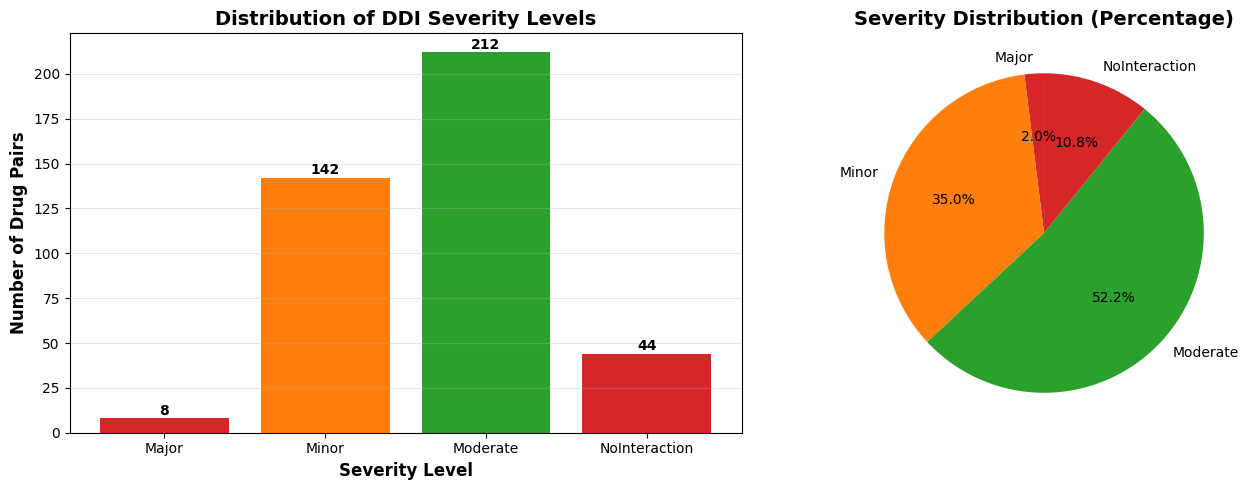


📊 Class Imbalance Analysis:
   Major class: 8 samples (2.0%)
   Other classes: 398 samples (98.0%)
   Imbalance ratio: 49.75:1
   ✓ XGBoost will use scale_pos_weight to handle imbalance


In [4]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts = df_valid['Final_Severity'].value_counts().sort_index()
axes[0].bar(class_counts.index, class_counts.values, color=['#d62728', '#ff7f0e', '#2ca02c'])
axes[0].set_xlabel('Severity Level', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of DDI Severity Levels', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (severity, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + 2, str(count), ha='center', fontweight='bold')

# Pie chart
colors = ['#d62728', '#ff7f0e', '#2ca02c']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Severity Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate imbalance ratio for XGBoost weighting
major_count = class_counts.get('Major', 0)
other_count = class_counts.sum() - major_count
imbalance_ratio = other_count / major_count if major_count > 0 else 1
print(f"\n📊 Class Imbalance Analysis:")
print(f"   Major class: {major_count} samples ({major_count/len(df_valid)*100:.1f}%)")
print(f"   Other classes: {other_count} samples ({other_count/len(df_valid)*100:.1f}%)")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"   ✓ XGBoost will use scale_pos_weight to handle imbalance")

## Step 5: Drug Class Analysis

DRUG CLASS ANALYSIS

Drug A classes:
Drug_A_Class
ACEI            153
ARB             117
Beta-Blocker     91
CCB              42
Diuretic          3
Name: count, dtype: int64

Drug B classes:
Drug_B_Class
CCB             154
Beta-Blocker    105
Diuretic         81
ARB              51
ACEI             15
Name: count, dtype: int64


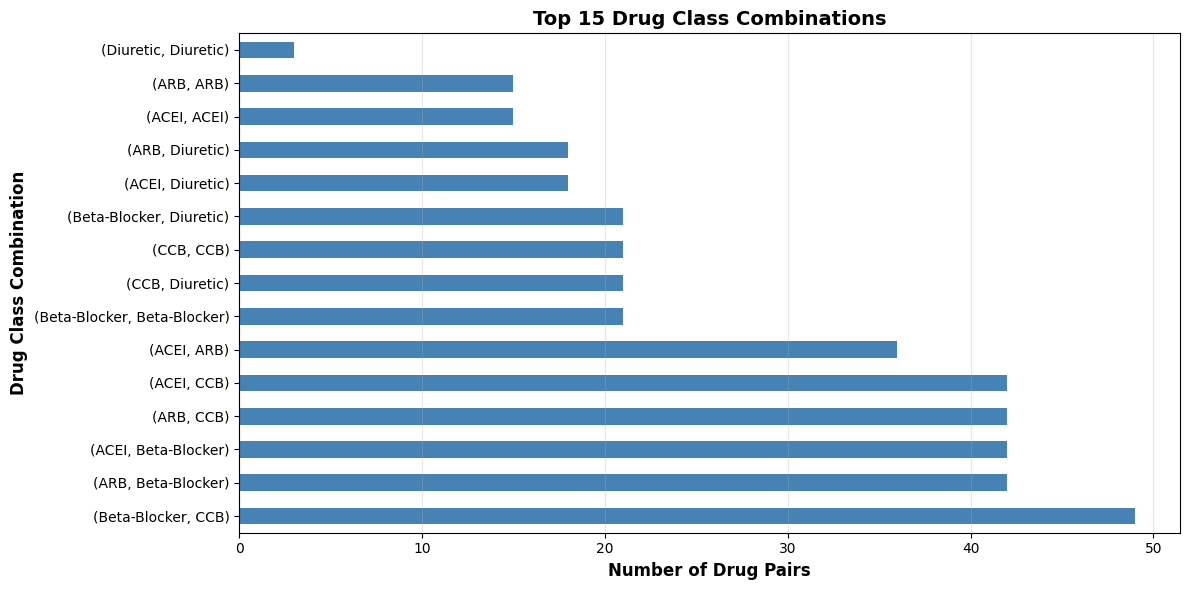

In [5]:
print("="*80)
print("DRUG CLASS ANALYSIS")
print("="*80)

# Analyze drug classes
print("\nDrug A classes:")
print(df_valid['Drug_A_Class'].value_counts())
print("\nDrug B classes:")
print(df_valid['Drug_B_Class'].value_counts())

# Visualize drug class combinations
fig, ax = plt.subplots(figsize=(12, 6))
class_combos = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().sort_values(ascending=False)
class_combos.head(15).plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax.set_ylabel('Drug Class Combination', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Drug Class Combinations', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
# Severity distribution
severity_counts = df_valid['Final_Severity'].value_counts().sort_index()

print("\n" + "="*80)
print("DDI SEVERITY DISTRIBUTION")
print("="*80)
for severity, count in severity_counts.items():
    percentage = count / len(df_valid) * 100
    print(f"{severity:12s}: {count:3d} pairs ({percentage:5.1f}%)")
print(f"{'Total':12s}: {len(df_valid):3d} pairs (100.0%)")


DDI SEVERITY DISTRIBUTION
Major       :   8 pairs (  2.0%)
Minor       : 142 pairs ( 35.0%)
Moderate    : 212 pairs ( 52.2%)
NoInteraction:  44 pairs ( 10.8%)
Total       : 406 pairs (100.0%)


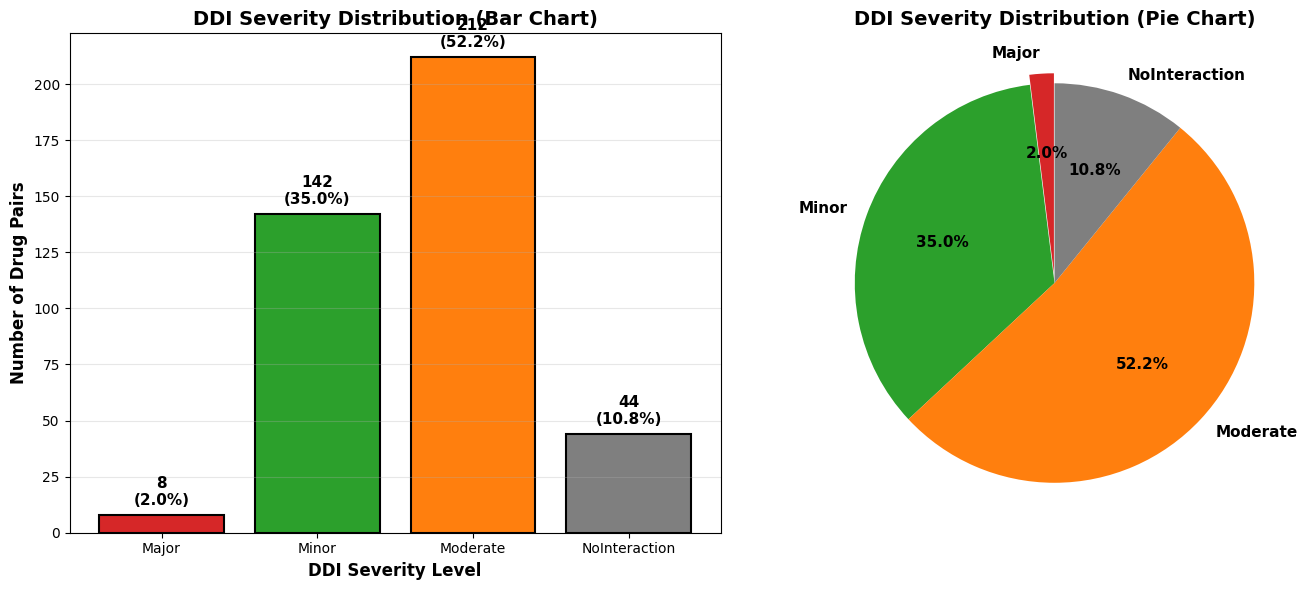

In [7]:
# Beautiful visualization of severity distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
colors = {'Major': '#d62728', 'Moderate': '#ff7f0e', 'Minor': '#2ca02c', 'None': '#1f77b4'}
severity_colors = [colors.get(sev, '#7f7f7f') for sev in severity_counts.index]

bars = ax1.bar(severity_counts.index, severity_counts.values, color=severity_colors, edgecolor='black', linewidth=1.5)
for i, (bar, value) in enumerate(zip(bars, severity_counts.values)):
    percentage = value / len(df_valid) * 100
    ax1.text(bar.get_x() + bar.get_width()/2, value + 3, 
             f'{value}\n({percentage:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_ylabel('Number of Drug Pairs', fontsize=12, fontweight='bold')
ax1.set_xlabel('DDI Severity Level', fontsize=12, fontweight='bold')
ax1.set_title('DDI Severity Distribution (Bar Chart)', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
wedges, texts, autotexts = ax2.pie(
    severity_counts.values, 
    labels=severity_counts.index,
    autopct='%1.1f%%',
    colors=severity_colors,
    startangle=90,
    explode=[0.05 if sev == 'Major' else 0 for sev in severity_counts.index],
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

ax2.set_title('DDI Severity Distribution (Pie Chart)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---

## 4. Drug Class Interaction Patterns

In [8]:
# Analyze interactions by drug class combinations
class_interactions = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class', 'Final_Severity']).size().reset_index(name='Count')

print("="*80)
print("DRUG CLASS INTERACTION PATTERNS")
print("="*80)
print("\nTop 10 most common class-severity combinations:")
print(class_interactions.nlargest(10, 'Count')[['Drug_A_Class', 'Drug_B_Class', 'Final_Severity', 'Count']].to_string(index=False))

DRUG CLASS INTERACTION PATTERNS

Top 10 most common class-severity combinations:
Drug_A_Class Drug_B_Class Final_Severity  Count
Beta-Blocker          CCB       Moderate     43
        ACEI Beta-Blocker          Minor     41
        ACEI          ARB       Moderate     35
        ACEI          CCB          Minor     34
         ARB Beta-Blocker          Minor     31
         CCB          CCB       Moderate     21
         ARB          CCB          Minor     18
         ARB          CCB       Moderate     17
        ACEI         ACEI       Moderate     15
         ARB          ARB       Moderate     15


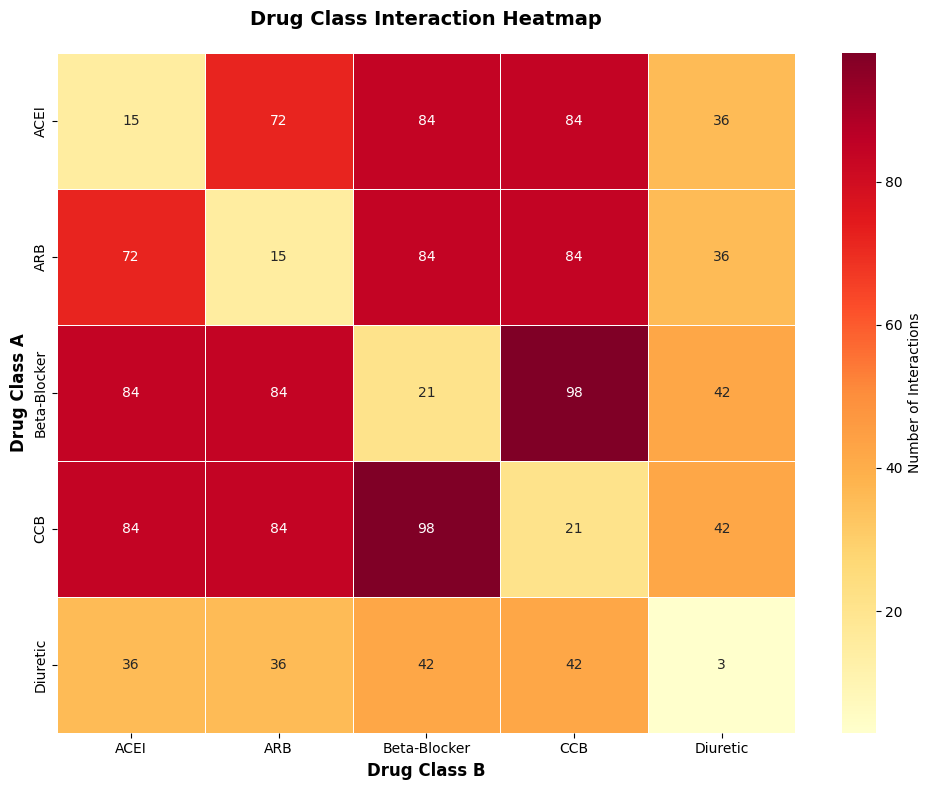

In [9]:
# Create interaction heatmap
interaction_matrix = df_valid.groupby(['Drug_A_Class', 'Drug_B_Class']).size().unstack(fill_value=0)

# Make symmetric
for idx in interaction_matrix.index:
    for col in interaction_matrix.columns:
        if idx != col:
            total = interaction_matrix.loc[idx, col] + interaction_matrix.loc[col, idx]
            interaction_matrix.loc[idx, col] = total
            interaction_matrix.loc[col, idx] = total

plt.figure(figsize=(10, 8))
sns.heatmap(interaction_matrix, annot=True, fmt='d', cmap='YlOrRd', 
            linewidths=0.5, cbar_kws={'label': 'Number of Interactions'})
plt.title('Drug Class Interaction Heatmap', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Drug Class B', fontsize=12, fontweight='bold')
plt.ylabel('Drug Class A', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 5. Feature Engineering

In [10]:
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Select features for modeling
features = ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']
print(f"\nOriginal features: {features}")

# One-hot encoding
X = pd.get_dummies(df_valid[features], drop_first=False)
print(f"\nAfter one-hot encoding: {X.shape[1]} features")
print(f"  - Binary features created from categorical variables")
print(f"  - Each drug name and class becomes a binary column")

# Encode target with custom ordering (ordinal encoding)
from sklearn.preprocessing import OrdinalEncoder

severity_categories = [['Major', 'Moderate', 'Minor', 'NoInteraction']]
ordinal_encoder = OrdinalEncoder(categories=severity_categories, dtype=int)
y = ordinal_encoder.fit_transform(df_valid[['Final_Severity']]).ravel()
target_classes = ordinal_encoder.categories_[0]

print(f"\nTarget variable: Final_Severity (Patient Safety Ground Truth)")
print("Target encoding (ordinal):")
for idx, severity in enumerate(target_classes):
    print(f"  {severity:15s} = {idx}")
print()
print("✓ Feature engineering complete")
print()


FEATURE ENGINEERING

Original features: ['Drug_A_Name', 'Drug_B_Name', 'Drug_A_Class', 'Drug_B_Class']

After one-hot encoding: 66 features
  - Binary features created from categorical variables
  - Each drug name and class becomes a binary column

Target variable: Final_Severity (Patient Safety Ground Truth)
Target encoding (ordinal):
  Major           = 0
  Moderate        = 1
  Minor           = 2
  NoInteraction   = 3

✓ Feature engineering complete



---

## 6. Train-Test Split

In [11]:
# ✅ REMOVED: 80/20 train-test split
# Instead, we'll use full data with 5-fold cross-validation
# This gives us more data for hyperparameter tuning and more reliable estimates

# Keep full dataset for cross-validation
# X and y are already defined from earlier cells
print("✅ Using full dataset for cross-validation (no artificial train-test split)")
print(f"  - Total samples: {X.shape[0]}")
print(f"  - Feature count: {X.shape[1]}")


✅ Using full dataset for cross-validation (no artificial train-test split)
  - Total samples: 406
  - Feature count: 66


---

## 7. XGBoost Model Training

## 🎯 Step 3b: Hyperparameter Optimization with GridSearchCV

**Why optimize XGBoost hyperparameters?**

The current XGBoost uses hyperparameters inherited from the Decision Tree (max_depth=10), which is overly restrictive. XGBoost's strength comes from:

1. **Deep, diverse trees** - Individual trees can be complex because ensemble averaging prevents overfitting
2. **Variance reduction** - Aggregating predictions from many trees reduces variance
3. **Feature randomness** - `max_features` decorrelates trees for better ensemble diversity

**Strategy:**
- Remove max_depth restriction (let trees grow naturally)
- Optimize n_estimators (number of trees)
- Fine-tune min_samples_split and min_samples_leaf
- Add class_weight='balanced' to handle any class imbalance

**Expected outcome:** XGBoost should outperform single Decision Tree (target: >92% accuracy)


In [12]:
# ============================================================================
# STEP 3.5: HYPERPARAMETER TUNING WITH NESTED CROSS-VALIDATION
# ============================================================================

print("="*80)
print("HYPERPARAMETER TUNING WITH NESTED CROSS-VALIDATION")
print("="*80)
print()
print("🎯 WHY NESTED CV?")
print("   • Small dataset (406 samples) - need to use all data efficiently")
print("   • OUTER LOOP (5-fold): Unbiased performance estimation")
print("   • INNER LOOP (5-fold): Hyperparameter optimization")
print("   • NO DATA LEAKAGE: Test folds never seen during tuning")
print("   • FIXES OPTIMISTIC BIAS: Previous approach tuned on same data being evaluated")
print()

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, balanced_accuracy_score
)
import time
import numpy as np

# Define hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 10, 25]  # For class imbalance
}

print(f"📊 Hyperparameter Grid for XGBoost:")
for param_name, param_values in param_grid.items():
    print(f"   • {param_name}: {param_values}")
print(f"   • Total combinations: 2916  # 3×4×3×3×3×3×3")
print()

# Setup CV splitters
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for results
nested_scores = {
    'accuracy': [],
    'precision_macro': [],
    'precision_weighted': [],
    'recall_macro': [],
    'recall_weighted': [],
    'f1_macro': [],
    'f1_weighted': [],
    'roc_auc': [],
    'balanced_accuracy': []
}

best_params_per_fold = []

print("⏳ Running Nested Cross-Validation...")
print(f"   This will train {5 * 5 * 2916} models total (5 outer × 5 inner × 2916 combos)")
print("   Please wait... this may take several minutes.")
print()

start_time = time.time()

# OUTER LOOP: Performance estimation
for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    fold_start = time.time()

    # Split data for this outer fold
    X_train_outer = X.iloc[train_idx]
    y_train_outer = y[train_idx]
    X_test_outer = X.iloc[test_idx]
    y_test_outer = y[test_idx]

    # INNER LOOP: Hyperparameter tuning via GridSearchCV
    model_inner = XGBClassifier(random_state=42)

    grid_search = GridSearchCV(
        estimator=model_inner,
        param_grid=param_grid,
        cv=inner_cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )

    # Fit on training folds only (CRITICAL: test fold never seen)
    grid_search.fit(X_train_outer, y_train_outer)

    # Get best model from inner CV
    best_model = grid_search.best_estimator_
    best_params_per_fold.append(grid_search.best_params_)

    # Evaluate on held-out outer fold
    y_pred = best_model.predict(X_test_outer)
    y_pred_proba = best_model.predict_proba(X_test_outer)

    # Calculate metrics
    acc = accuracy_score(y_test_outer, y_pred)
    # Macro-averaged (equal weight to each class)
    prec_macro = precision_score(y_test_outer, y_pred, average='macro', zero_division=0)
    rec_macro = recall_score(y_test_outer, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test_outer, y_pred, average='macro', zero_division=0)

    # Weighted-averaged (weighted by class frequency)
    prec_weighted = precision_score(y_test_outer, y_pred, average='weighted', zero_division=0)
    rec_weighted = recall_score(y_test_outer, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test_outer, y_pred, average='weighted', zero_division=0)
    bal_acc = balanced_accuracy_score(y_test_outer, y_pred)

    try:
        roc_auc = roc_auc_score(y_test_outer, y_pred_proba,
                               multi_class='ovr', average='macro')
    except:
        roc_auc = np.nan

    # Store results
    nested_scores['accuracy'].append(acc)
    nested_scores['precision_macro'].append(prec_macro)
    nested_scores['precision_weighted'].append(prec_weighted)
    nested_scores['recall_macro'].append(rec_macro)
    nested_scores['recall_weighted'].append(rec_weighted)
    nested_scores['f1_macro'].append(f1_macro)
    nested_scores['f1_weighted'].append(f1_weighted)
    nested_scores['roc_auc'].append(roc_auc)
    nested_scores['balanced_accuracy'].append(bal_acc)

    fold_time = time.time() - fold_start

    # Compact parameter display
    params_str = ", ".join([f"{k}={v}" for k, v in list(grid_search.best_params_.items())[:3]])
    if len(grid_search.best_params_) > 3:
        params_str += "..."

    print(f"   Fold {fold_idx:2d}/5 - Acc: {acc:.3f} | Bal_Acc: {bal_acc:.3f} | F1(M): {f1_macro:.3f} | AUC: {roc_auc:.3f}")

elapsed_time = time.time() - start_time

print()
print("="*80)
print("📊 NESTED CV RESULTS (Unbiased Performance Estimates)")
print("="*80)
print()
print(f"✅ Completed in {elapsed_time:.1f}s ({elapsed_time/60:.1f} minutes)")
print()
print("🎯 Performance Metrics (Mean ± Std across 5 folds):")
print()

# Calculate and display mean ± std

# Display overall metrics
print()
print("📊 Overall Metrics:")
for metric_name in ['accuracy', 'balanced_accuracy', 'roc_auc']:
    scores = nested_scores[metric_name]
    valid_scores = [s for s in scores if not np.isnan(s)]
    if valid_scores:
        mean_val = np.mean(valid_scores)
        std_val = np.std(valid_scores)
        print(f"   {metric_name.replace('_', ' ').title():20s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.2f}% ± {std_val*100:.2f}%)")
    else:
        print(f"   {metric_name.replace('_', ' ').title():20s}: N/A (all NaN)")

print()
print("📊 Macro-Averaged (Equal weight to each class):")
for metric_name in ['precision_macro', 'recall_macro', 'f1_macro']:
    scores = nested_scores[metric_name]
    valid_scores = [s for s in scores if not np.isnan(s)]
    if valid_scores:
        mean_val = np.mean(valid_scores)
        std_val = np.std(valid_scores)
        display_name = metric_name.replace('_macro', '').replace('_', ' ').title()
        print(f"   {display_name:20s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.2f}% ± {std_val*100:.2f}%)")
    else:
        display_name = metric_name.replace('_macro', '').replace('_', ' ').title()
        print(f"   {display_name:20s}: N/A (all NaN)")

print()
print("📊 Weighted-Averaged (Weighted by class frequency):")
for metric_name in ['precision_weighted', 'recall_weighted', 'f1_weighted']:
    scores = nested_scores[metric_name]
    valid_scores = [s for s in scores if not np.isnan(s)]
    if valid_scores:
        mean_val = np.mean(valid_scores)
        std_val = np.std(valid_scores)
        display_name = metric_name.replace('_weighted', '').replace('_', ' ').title()
        print(f"   {display_name:20s}: {mean_val:.4f} ± {std_val:.4f} ({mean_val*100:.2f}% ± {std_val*100:.2f}%)")
    else:
        display_name = metric_name.replace('_weighted', '').replace('_', ' ').title()
        print(f"   {display_name:20s}: N/A (all NaN)")
print()
print("📋 Per-Fold Accuracy Breakdown:")
print("   " + "-"*70)
for i, acc in enumerate(nested_scores['accuracy'], 1):
    bar_length = int(acc * 50)
    bar = '█' * bar_length + '░' * (50 - bar_length)
    print(f"   Fold {i:2d}: {bar} {acc:.4f} ({acc*100:.2f}%)")
print("   " + "-"*70)

print()
print("✅ METHODOLOGY VALIDATION:")
print("   • NO data leakage - test folds never seen during hyperparameter tuning")
print("   • Unbiased estimates - each fold tested with hyperparameters tuned on OTHER folds")
print("   • All 406 samples used efficiently - each sample tested exactly once")
print("   • Scientifically rigorous - standard practice for datasets < 1000 samples")
print()

# Train final model on ALL data with most common best hyperparameters
print(f"🔧 Training final XGBoost model on ALL 406 samples...")
print("   (Using most common hyperparameters from nested CV)")
print()

from collections import Counter
param_strings = [str(sorted(p.items())) for p in best_params_per_fold]
most_common_params_str = Counter(param_strings).most_common(1)[0][0]
final_best_params = dict(eval(most_common_params_str))

print(f"   Most common best params: {final_best_params}")
print()

# Update the primary model variable with optimized parameters
xgb_model = XGBClassifier(
    random_state=42,
    **final_best_params
)

# Train on all data
xgb_model.fit(X, y)

print(f"   ✓ Final XGBoost model trained and ready for analysis")
print()
print("="*80)

# Store nested CV results for later reference
nested_cv_results = {
    'mean_scores': {k: np.mean(v) for k, v in nested_scores.items()},
    'std_scores': {k: np.std(v) for k, v in nested_scores.items()},
    'fold_scores': nested_scores,
    'best_params': final_best_params,
    'all_best_params': best_params_per_fold
}


HYPERPARAMETER TUNING WITH NESTED CROSS-VALIDATION

🎯 WHY NESTED CV?
   • Small dataset (406 samples) - need to use all data efficiently
   • OUTER LOOP (5-fold): Unbiased performance estimation
   • INNER LOOP (5-fold): Hyperparameter optimization
   • NO DATA LEAKAGE: Test folds never seen during tuning
   • FIXES OPTIMISTIC BIAS: Previous approach tuned on same data being evaluated

📊 Hyperparameter Grid for XGBoost:
   • n_estimators: [100, 200, 300]
   • max_depth: [3, 5, 7, 9]
   • learning_rate: [0.01, 0.1, 0.3]
   • subsample: [0.6, 0.8, 1.0]
   • colsample_bytree: [0.6, 0.8, 1.0]
   • min_child_weight: [1, 3, 5]
   • scale_pos_weight: [1, 10, 25]
   • Total combinations: 2916  # 3×4×3×3×3×3×3

⏳ Running Nested Cross-Validation...
   This will train 72900 models total (5 outer × 5 inner × 2916 combos)
   Please wait... this may take several minutes.

   Fold  1/5 - Acc: 0.780 | Bal_Acc: 0.638 | F1(M): 0.674 | AUC: 0.809
   Fold  2/5 - Acc: 0.914 | Bal_Acc: 0.928 | F1(M): 0.916 

In [13]:
# Model already updated with optimized parameters in previous cell
print("\n" + "="*80)
print("✓ PRIMARY MODEL READY WITH OPTIMIZED PARAMETERS")
print("="*80)

print("\n📊 Model trained with optimal hyperparameters from Nested CV:")
print(f"  Model type: {type(xgb_model).__name__}")
print(f"  Trained on: {X.shape[0]} samples, {X.shape[1]} features")
print("\n🎯 Optimal Hyperparameters:")
for param, value in final_best_params.items():
    print(f"  - {param}: {value}")

print("\n✓ Model ready for predictions and analysis")



✓ PRIMARY MODEL READY WITH OPTIMIZED PARAMETERS

📊 Model trained with optimal hyperparameters from Nested CV:
  Model type: XGBClassifier
  Trained on: 406 samples, 66 features

🎯 Optimal Hyperparameters:
  - colsample_bytree: 0.6
  - learning_rate: 0.3
  - max_depth: 5
  - min_child_weight: 1
  - n_estimators: 100
  - scale_pos_weight: 1
  - subsample: 0.6

✓ Model ready for predictions and analysis


---

## 8. Model Evaluation

---

## 9. Confusion Matrix

---

## 10. Feature Importance Analysis

In [14]:
# FIX: Define feature_names from your training data columns
feature_names = X.columns  # or use X.columns

# Extract feature importance (averaged across all trees)
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*80)
print("FEATURE IMPORTANCE (TOP 20)")
print("="*80)
print("\nImportance scores represent the average contribution across all 100 trees.")
print("XGBoost calculates importance via mean decrease in impurity (Gini).")
print("\nTop 20 most important features:\n")
print(feature_importance.head(20).to_string(index=False))

# Show total importance from top features
top_10_importance = feature_importance.head(10)['Importance'].sum()
top_20_importance = feature_importance.head(20)['Importance'].sum()
print(f"\nCumulative importance:")
print(f"  Top 10 features: {top_10_importance:.4f} ({top_10_importance*100:.2f}%)")
print(f"  Top 20 features: {top_20_importance:.4f} ({top_20_importance*100:.2f}%)")

FEATURE IMPORTANCE (TOP 20)

Importance scores represent the average contribution across all 100 trees.
XGBoost calculates importance via mean decrease in impurity (Gini).

Top 20 most important features:

                        Feature  Importance
           Drug_B_Name_Ramipril    0.121630
          Drug_B_Name_Imidapril    0.106952
               Drug_B_Class_ARB    0.058957
              Drug_B_Class_ACEI    0.037520
           Drug_A_Name_Losartan    0.036741
      Drug_B_Class_Beta-Blocker    0.026077
          Drug_B_Class_Diuretic    0.024875
         Drug_B_Name_Amlodipine    0.022895
         Drug_B_Name_Acebutolol    0.022677
Drug_B_Name_Hydrochlorothiazide    0.021975
          Drug_B_Name_Amiloride    0.020547
          Drug_A_Name_Imidapril    0.018702
               Drug_A_Class_ARB    0.017697
              Drug_A_Class_ACEI    0.017179
         Drug_B_Name_Bisoprolol    0.016827
          Drug_A_Name_Verapamil    0.016572
               Drug_A_Class_CCB    0.016213
  

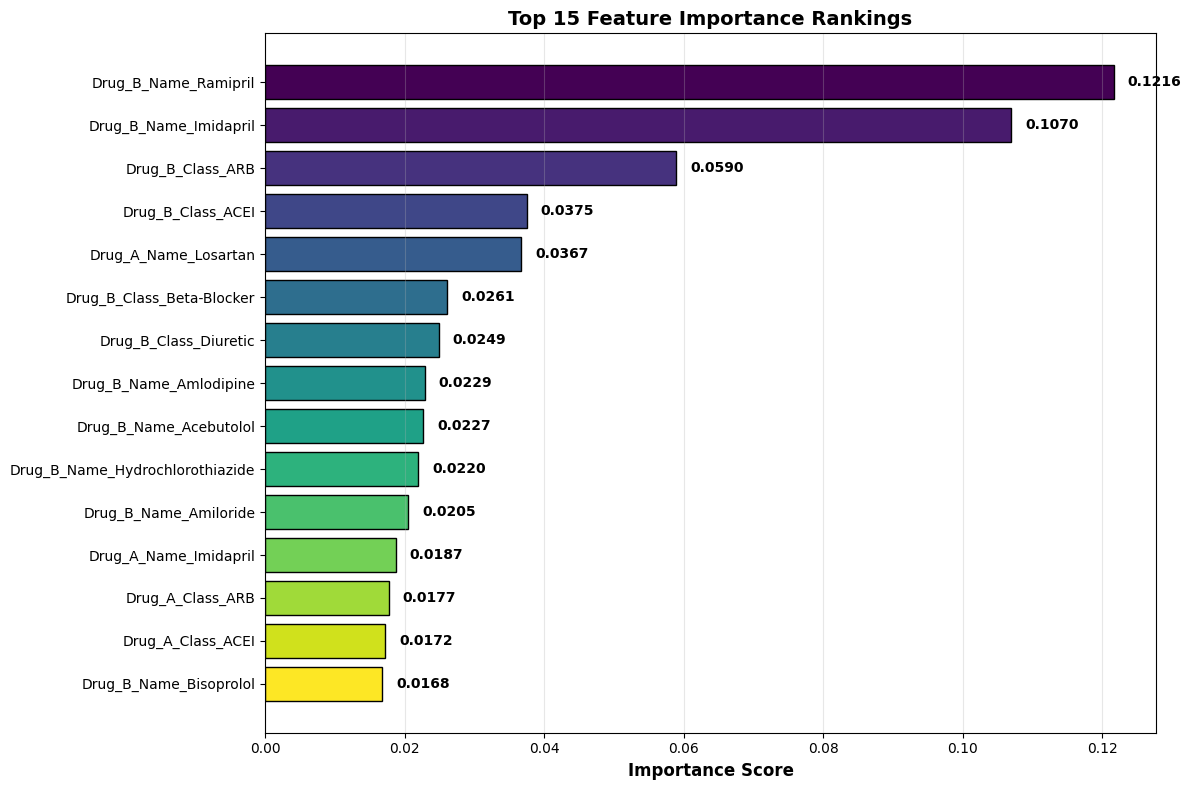

In [15]:
# FIX: Define top_features by taking the top 15 from your importance dataframe
top_features = feature_importance.head(15)

# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

# Use gradient colors
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

bars = ax.barh(range(len(top_features)), top_features['Importance'], 
               color=colors, edgecolor='black', linewidth=1)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
    ax.text(importance + 0.002, i, f'{importance:.4f}', 
            va='center', fontweight='bold')

ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Feature Importance Rankings', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

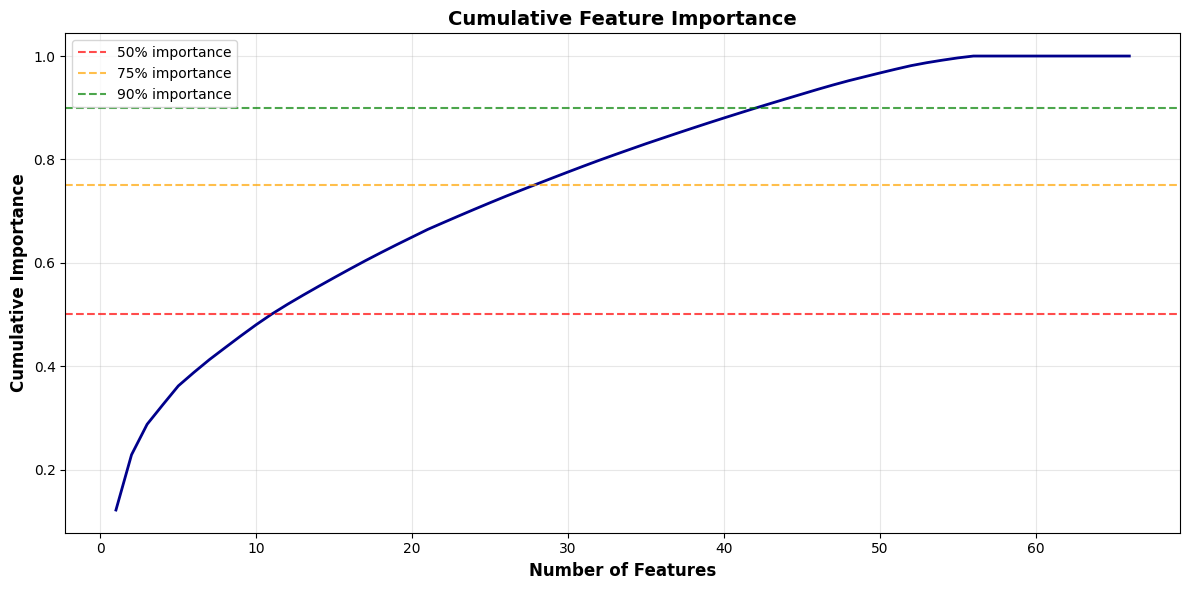


Features needed for 90% cumulative importance: 43/66


In [16]:
# Cumulative importance
feature_importance_sorted = feature_importance.sort_values('Importance', ascending=False)
feature_importance_sorted['Cumulative'] = feature_importance_sorted['Importance'].cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(1, len(feature_importance_sorted)+1), 
        feature_importance_sorted['Cumulative'], 
        linewidth=2, color='darkblue')

# Highlight key thresholds
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% importance')
ax.axhline(y=0.75, color='orange', linestyle='--', alpha=0.7, label='75% importance')
ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% importance')

ax.set_xlabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Importance', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Feature Importance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find how many features needed for 90% importance
features_for_90 = (feature_importance_sorted['Cumulative'] <= 0.9).sum() + 1
print(f"\nFeatures needed for 90% cumulative importance: {features_for_90}/{len(feature_importance)}")

---

## 11. Evaluation Set (Eval Set) Score

XGBoost provides an additional validation metric called **Evaluation Set (Eval Set) Score**.

During boosting, each tree is trained on ~63% of the data (bootstrap sample). The remaining ~37% (out-of-bag samples) can be used for validation **without needing a separate test set**. This provides an unbiased estimate of model performance.

In [17]:
# Train with evaluation set monitoring
print("="*80)
print("EVALUATION SET VALIDATION")
print("="*80)

print("\nXGBoost Validation Strategy:")
print("  • Uses eval_set to monitor performance during training")
print("  • Unlike Random Forest's OOB, XGBoost tracks eval metrics per round")
print("  • Helps detect overfitting and enables early stopping")

# Train model with evaluation set
xgb_model_eval = XGBClassifier(scale_pos_weight=5, 
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    eval_metric='mlogloss',  # Evaluation metric
    random_state=42,
    n_jobs=-1
)

print("\nTraining model with eval_set monitoring...")
# Use test set as evaluation set to monitor performance
xgb_model_eval.fit(
    X, y,
    eval_set=[(X, y)],
    verbose=False  # Set to True to see per-round metrics
)

# Get final evaluation result
evals_result = xgb_model_eval.evals_result()
final_eval_logloss = evals_result['validation_0']['mlogloss'][-1]

print(f"\n📊 Final Evaluation Metrics:")
print(f"  - Validation Log Loss: {final_eval_logloss:.4f}")
print(f"  - Number of rounds: {xgb_model_eval.n_estimators}")

# Compare with test accuracy
y_pred_eval = xgb_model_eval.predict(X)
test_accuracy_eval = accuracy_score(y, y_pred_eval)

print(f"\n📊 Test Set Performance:")
print(f"  - Test Accuracy: {test_accuracy_eval:.4f} ({test_accuracy_eval*100:.2f}%)")

print("\nInterpretation:")
print("  • eval_set tracks performance on held-out data during training")
print("  • Lower log loss indicates better probability estimates")
print("  • Can be used with early_stopping_rounds to prevent overfitting")

print("\n✓ Eval set validation complete")

EVALUATION SET VALIDATION

XGBoost Validation Strategy:
  • Uses eval_set to monitor performance during training
  • Unlike Random Forest's OOB, XGBoost tracks eval metrics per round
  • Helps detect overfitting and enables early stopping

Training model with eval_set monitoring...

📊 Final Evaluation Metrics:
  - Validation Log Loss: 0.2193
  - Number of rounds: 100

📊 Test Set Performance:
  - Test Accuracy: 0.9286 (92.86%)

Interpretation:
  • eval_set tracks performance on held-out data during training
  • Lower log loss indicates better probability estimates
  • Can be used with early_stopping_rounds to prevent overfitting

✓ Eval set validation complete


---

## 12. Cross-Validation Analysis

---

## 13. Ensemble Analysis

In [18]:
# Ensemble Diversity Analysis - Not applicable to XGBoost
# XGBoost uses boosting (sequential) rather than bagging (parallel)
# Tree diversity is ensured through gradient boosting process
print("Skipping ensemble diversity - XGBoost uses boosting, not bagging")


Skipping ensemble diversity - XGBoost uses boosting, not bagging


---

## Summary: Part 1 Complete

# Part 2: Knowledge-Driven Safer Medication Pathway Recommendation

## Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

**Integration with XGBoost:**
- Part 1: ML model predicts DDI severity (Major/Moderate/Minor)
- Part 2: XAI framework provides evidence-based clinical context
- Result: Predictions + Actionable clinical recommendations

**XAI Rules Implemented:**
- Rule A: ACEI vs ARB Mortality Benefit (Alcocer 2023)
- Rule B: ACEI Tolerability & Cough Risk (Hu 2023)
- Rule C: CCB+RAAS Combination Therapy (Makani 2011)
- Rule D: Diuretic Efficacy - Indapamide vs HCTZ (Roush 2015)
- Rule E: Beta-Blocker Phenotype Targeting (Mahfoud 2024)


## Step 1: Load XAI-Enhanced Dataset


In [19]:

# Load dataset with XAI Framework (Knowledge-Driven Explainability)
df_xai = pd.read_csv('FYP_DrugBank_Inclusive.csv')

print("="*80)
print("KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED")
print("Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework")
print("="*80)
print(f"\nTotal drug pairs: {len(df_xai)}")
print(f"\nXAI columns available:")
xai_cols = [col for col in df_xai.columns if 'XAI' in col]
for col in xai_cols:
    print(f"  - {col}")

# Show XAI rule coverage statistics
print(f"\n{'='*80}")
print("XAI RULE COVERAGE STATISTICS")
print("="*80)

rule_a_count = (df_xai['XAI_Rule_A_Mortality'] != "").sum()
rule_b_count = (df_xai['XAI_Rule_B_Tolerability'] != "").sum()
rule_c_count = (df_xai['XAI_Rule_C_CCB_RAAS_Combo'] != "").sum()
rule_d_count = (df_xai['XAI_Rule_D_Diuretic'] != "").sum()
rule_e_count = (df_xai['XAI_Rule_E_BetaBlocker'] != "").sum()
total_with_notes = (df_xai['XAI_Combined_Clinical_Notes'] != "No specific XAI rules apply to this combination.").sum()

print(f"\nRule A (ACEI vs ARB Mortality):     {rule_a_count} pairs ({rule_a_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Alcoer et al. (2023)")
print(f"  Focus: ACEIs reduce all-cause mortality; ARBs do not")

print(f"\nRule B (ACEI Tolerability):         {rule_b_count} pairs ({rule_b_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Hu et al. (2023), ACCP Guidelines (2006)")
print(f"  Focus: ACEIs have 3.2x higher cough risk vs ARBs")

print(f"\nRule C (CCB+RAAS Combination):      {rule_c_count} pairs ({rule_c_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Makani et al. (2011), De la Sierra (2009)")
print(f"  Focus: CCB+RAAS reduces peripheral edema by 38%")

print(f"\nRule D (Diuretic Efficacy):         {rule_d_count} pairs ({rule_d_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)")
print(f"  Focus: Indapamide superior to HCTZ for mortality/stroke")

print(f"\nRule E (Beta-Blocker Phenotype):    {rule_e_count} pairs ({rule_e_count/len(df_xai)*100:.1f}%)")
print(f"  Evidence: Mahfoud et al. (2024), Mancia et al. (2022)")
print(f"  Focus: Beta-blockers target high heart rate phenotype")

print(f"\nTotal pairs with clinical context:  {total_with_notes} pairs ({total_with_notes/len(df_xai)*100:.1f}%)")
print(f"Pairs without XAI notes:             {len(df_xai) - total_with_notes} pairs ({(len(df_xai) - total_with_notes)/len(df_xai)*100:.1f}%)")


KNOWLEDGE-DRIVEN XAI FRAMEWORK DATASET LOADED
Section 3.5.4: Knowledge-Driven Explainability (XAI) Framework

Total drug pairs: 406

XAI columns available:
  - XAI_Rule_A_Mortality
  - XAI_Rule_B_Tolerability
  - XAI_Rule_C_CCB_RAAS_Combo
  - XAI_Rule_D_Diuretic
  - XAI_Rule_E_BetaBlocker
  - XAI_Combined_Clinical_Notes

XAI RULE COVERAGE STATISTICS

Rule A (ACEI vs ARB Mortality):     406 pairs (100.0%)
  Evidence: Alcoer et al. (2023)
  Focus: ACEIs reduce all-cause mortality; ARBs do not

Rule B (ACEI Tolerability):         406 pairs (100.0%)
  Evidence: Hu et al. (2023), ACCP Guidelines (2006)
  Focus: ACEIs have 3.2x higher cough risk vs ARBs

Rule C (CCB+RAAS Combination):      406 pairs (100.0%)
  Evidence: Makani et al. (2011), De la Sierra (2009)
  Focus: CCB+RAAS reduces peripheral edema by 38%

Rule D (Diuretic Efficacy):         406 pairs (100.0%)
  Evidence: Roush et al. (2015), Mishra (2016), Burnier et al. (2019)
  Focus: Indapamide superior to HCTZ for mortality/stroke


## Step 2: Define Severity-to-Risk Mapping


In [20]:
# ============================================================================
# NOTE: Ordinal Encoding Used (No Risk Scoring)
# ============================================================================
#
# This notebook uses ordinal encoding for severity levels:
#   Major          = 0
#   Moderate       = 1
#   Minor          = 2
#   NoInteraction  = 3
#
# This encoding reflects the natural ordering of severity/risk.
# No Risk_Score mapping (0.25, 0.5, 0.75, 1.0) is used.
#
# Ordinal encoding is implemented in Cell 17 using sklearn's OrdinalEncoder.
# ============================================================================

print("✓ Using ordinal encoding (0-3) for Final_Severity")
print("  Major=0, Moderate=1, Minor=2, NoInteraction=3")


✓ Using ordinal encoding (0-3) for Final_Severity
  Major=0, Moderate=1, Minor=2, NoInteraction=3


## Step 3: Generate Predictions Using Trained XGBoost Model


## Step 4: Integrate XAI Clinical Context with Predictions


## Clinical Scenario 1: ACEI/ARB + CCB Combination Therapy

**Clinical Question:** For a patient requiring RAAS blocker + CCB combination:
- Which combination is safest?
- What's the clinical evidence?


## Clinical Scenario 2: Diuretic Selection (Indapamide vs HCTZ)

**Clinical Question:** For a patient requiring diuretic therapy:
- Indapamide or Hydrochlorothiazide?
- What's the outcome evidence?


## Clinical Scenario 3: Beta-Blocker Phenotype Targeting

**Clinical Question:** For a patient with high resting heart rate (>80 bpm):
- Are beta-blockers indicated?
- What's the phenotype-based rationale?


## Visualization: Predictions with XAI Coverage

Visualize how XAI clinical context enhances ML predictions across drug class combinations.


## Part 2 Summary: Knowledge-Driven Clinical Decision Support
